# Deep model for *rate* variable classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import os
from sklearn.utils import class_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


## Useful functions

In [0]:
def load_data():
    train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/Train.csv", sep=";", error_bad_lines=False)
    test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/TestX.csv", sep=";", error_bad_lines=False)
    return train, test



def prepare_inputs(X_train, X_val, X_test):
    X_train_enc, X_val_enc, X_test_enc = list(), list(), list()
    # label encode each column

    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # le.fit(X_train[:, i])
        # le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0).astype(str))
        le.fit(np.concatenate((X_train[:, i], X_val[:, i], X_test[:, i]), axis=0))
        # encode
        train_enc = le.transform(X_train[:, i])
        val_enc = le.transform(X_val[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_val_enc.append(val_enc)
        X_test_enc.append(test_enc)
        
    return X_train_enc, X_val_enc, X_test_enc


def prepare_outputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # le.fit(X_train[:, i])
        # le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0).astype(str))
        le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0))
        # encode
        train_enc = le.transform(X_train[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc


def train_val_split(train_data, rate=0.9, unique=True):
    if unique == True:
        unique_opinions = pd.unique(train_data["opinion"].values)
        train = train_data.loc[train_data["opinion"].isin(unique_opinions[:int(unique_opinions.shape[0]*rate)])]
        val = train_data.loc[train_data["opinion"].isin(unique_opinions[int(unique_opinions.shape[0]*rate):])]
        return train, val
    else:
        train, val = train_test_split(train_data, test_size=(1-rate))
        return train, val 

def decode_sentence(text, reverse_word_index):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


def plot_history(history, metric="rate_"):
    # Plot training & validation accuracy values
    plt.plot(history.history[metric + 'accuracy'])
    plt.plot(history.history['val_' + metric + 'accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history[metric + 'loss'])
    plt.plot(history.history['val_' + metric + 'loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## code

#### define static vars

In [0]:
VOCAB_SIZE = 5000
EMB_DIM = 64
MAX_LEN = 400
TRUNC_TYPE = 'post'
PAD_TYPE = 'post'
OOV_TOK = '<OOV>'

#### load and preprocess dataset

In [6]:
train, test = load_data()
train, test = train.dropna(), test.dropna()
train, val = train_val_split(train, rate=0.9)
# train, val = train_val_split(train, rate=0.9, unique=False)
train, val = train.reset_index(), val.reset_index()


train_posts, val_posts, test_posts = train['opinion'], val['opinion'], test['opinion']
X_train_enc, X_val_enc, X_test_enc = prepare_inputs(train[["name", "condition"]].values, val[["name", "condition"]].values, test[["name", "condition"]].values)
# train_labels, val_labels = train['rate1'], val['rate1']
train_labels, val_labels= prepare_outputs(train[['rate', 'rate1']].values, val[['rate', 'rate1']].values)
# train_labels, val_labels = train_labels[0], val_labels[0]
print("train shape: {}, val shape: {}".format(train.shape, val.shape))

train shape: (137496, 6), val shape: (11665, 6)


In [7]:
print("train encoded", X_train_enc, np.max(X_train_enc[1]))
print("test encoded", X_test_enc, np.max(X_test_enc[1]))

train encoded [array([3537, 1248, 3265, ..., 2708, 2920, 2553]), array([331, 744, 171, ..., 130, 522, 236])] 906
test encoded [array([3447, 1642,  530, ..., 3517,  225, 1082]), array([852, 171, 129, ...,  83, 157,   0])] 906


#### class weights calculate

#### fit tokenizer on words in opiniions

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(pd.concat((train_posts, val_posts), axis=0))
word_index = tokenizer.word_index
print("sample tokens: ", dict(list(word_index.items())[0:100]))
print("sample tokens: ", dict(list(word_index.items())[4900:5000]))

sample tokens:  {'<OOV>': 1, 'i': 2, 'and': 3, 'the': 4, 'to': 5, 'it': 6, 'my': 7, 'a': 8, '039': 9, 'for': 10, 'was': 11, 'have': 12, 'of': 13, 'on': 14, 'this': 15, 'in': 16, 'but': 17, 'me': 18, 'had': 19, 'is': 20, 'that': 21, 'with': 22, 't': 23, 'not': 24, 'so': 25, 'been': 26, 'at': 27, 'after': 28, 'no': 29, 'day': 30, 'am': 31, 'as': 32, 'about': 33, 'm': 34, 'now': 35, 'side': 36, 'taking': 37, 'all': 38, 'has': 39, 've': 40, 's': 41, 'years': 42, 'pain': 43, 'effects': 44, 'first': 45, 'take': 46, 'you': 47, 'months': 48, 'only': 49, 'started': 50, '2': 51, 'like': 52, 'get': 53, 'up': 54, 'be': 55, 'days': 56, 'just': 57, 'very': 58, 'time': 59, 'out': 60, 'from': 61, 'or': 62, 'when': 63, '3': 64, 'can': 65, 'feel': 66, 'if': 67, 'would': 68, 'because': 69, 'back': 70, 'pill': 71, 'more': 72, 'one': 73, 'weeks': 74, 'are': 75, 'week': 76, 'doctor': 77, 'also': 78, 'took': 79, 'period': 80, 'medication': 81, 'weight': 82, 'before': 83, 'then': 84, 'got': 85, 'will': 86, 'd

#### tokenize words in opinions in train and val dataset


In [9]:
train_sequences = tokenizer.texts_to_sequences(train_posts)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_LEN,
                                                             padding=PAD_TYPE, truncating=TRUNC_TYPE)
validation_sequences = tokenizer.texts_to_sequences(val_posts)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=MAX_LEN,
                                                                  padding=PAD_TYPE, truncating=TRUNC_TYPE)

test_sequences = tokenizer.texts_to_sequences(test_posts)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_LEN,
                                                                  padding=PAD_TYPE, truncating=TRUNC_TYPE)
print("sample tokenized sentence: ", train_sequences[10])
print("sample tokenized sentence: ", test_sequences[10])

sample tokenized sentence:  [15, 141, 326, 28, 8, 96, 667, 5, 1218, 6, 20, 315, 24, 100, 107, 61, 30, 73, 2, 12, 19, 403, 3, 4, 4305, 16, 7, 1003, 20, 95, 2105, 35, 4, 706, 977, 75, 2995, 54, 17, 6, 20, 4, 990, 43, 3, 4, 1463, 70, 43, 21, 46, 15, 141, 60, 13, 4, 1193, 2, 31, 577, 97, 13, 6, 2, 65, 9, 23, 1345, 10, 15, 141, 5, 2022, 18, 174, 39, 26, 8, 298, 210, 64, 56, 13, 563, 6, 55, 1, 55, 2186]
sample tokenized sentence:  [7, 1159, 20, 427, 130, 51, 42, 199, 3, 39, 26, 998, 16, 8, 3473, 503, 10, 4, 313, 138, 42, 145, 122, 228, 569, 157, 98, 24, 101, 143, 4506, 13, 154, 282, 224, 400, 636, 3337, 27, 4, 3769, 13, 4, 567, 4, 3473, 503, 160, 400, 14, 246, 150, 744, 3, 400, 171, 791, 224, 154, 421, 22, 29, 36, 44, 228, 11, 1, 131, 3, 11, 1809, 5, 46, 92, 32, 6, 326, 400, 270, 5, 213, 67, 228, 155, 596, 14, 8, 438, 148, 33, 8, 88, 132, 110, 982, 400, 148, 5, 138, 150, 3, 4, 98, 1002, 316, 400, 148, 11, 1294, 70, 54, 5, 246, 150, 3, 260, 75, 1, 8, 1338, 5, 400, 615, 561, 612]


#### check tokenization

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original: ", train_posts[0])
print('---')
print("Tokenized then decoded: ", decode_sentence(train_padded[0], reverse_word_index))

Original:  "Using it as a replacement for Nexium, since insurance refused to cover Nexium. Works like a charm, and my GERD is under control now. Sometimes it&#039;s a bit of a hassle to have to wait half an hour before eating in the morning, especially when in a hurry, but this is an incredibly mild inconvenience when compared to the benefits."
---
Tokenized then decoded:  using it as a replacement for nexium since insurance refused to cover nexium works like a charm and my gerd is under control now sometimes it 039 s a bit of a hassle to have to wait half an hour before eating in the morning especially when in a <OOV> but this is an incredibly mild <OOV> when compared to the benefits ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 

#### Model 

In [11]:
#%% define recurrent part of model
in1 = tf.keras.layers.Input(shape=(400,))
h1 = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM)(in1)
# h1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM, return_sequences=True))(h1)
h12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM, return_sequences=True))(h1)
h12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMB_DIM))(h12)
h13 = tf.keras.layers.Dense(EMB_DIM, activation='relu')(h12)

#%% define other parts of models (input and dense layers for condition and drug)
in_layers = list()
em_layers = list()
d_layers = list()
for i in range(len(X_train_enc)):
    # TODO: check if it is ok to know that there will be new drugs/conditions for embedding layer
    # calculate the number of unique inputs
    n_labels = len(np.unique(np.concatenate((X_train_enc[i], X_val_enc[i], X_test_enc[i]), axis=0)))
    # define input layer
    in_layer = tf.keras.layers.Input(shape=(1,))
    # define embedding layer
    em_layer = tf.keras.layers.Embedding(n_labels+1, 10,  input_length=1)(in_layer)
    # dense for concat
    dense_layer = tf.keras.layers.Flatten()(em_layer)
    # store layers
    in_layers.append(in_layer)
    em_layers.append(em_layer)
    d_layers.append(dense_layer)

d_layers.append(h13)
in_layers.append(in1)

#%% define final model
merge = tf.keras.layers.concatenate(d_layers)
dense = tf.keras.layers.Dense(80, activation='relu', kernel_initializer='he_normal')(merge)
dense = tf.keras.layers.BatchNormalization()(dense)
dense = tf.keras.layers.Dropout(0.3)(dense)
dense = tf.keras.layers.Dense(40, activation='relu', kernel_initializer='he_normal')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
dense = tf.keras.layers.BatchNormalization()(dense)
dense = tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal')(dense)
dense = tf.keras.layers.Dropout(0.1)(dense)
dense = tf.keras.layers.BatchNormalization()(dense)
output = tf.keras.layers.Dense(10, activation='softmax', name="rate")(dense)
output2 = tf.keras.layers.Dense(3, activation='softmax', name="rate1")(dense)
output3 = tf.keras.layers.Dense(1, activation='relu', name="rate_reg")(dense)
model = tf.keras.models.Model(inputs=in_layers, outputs=[output, output2, output3])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

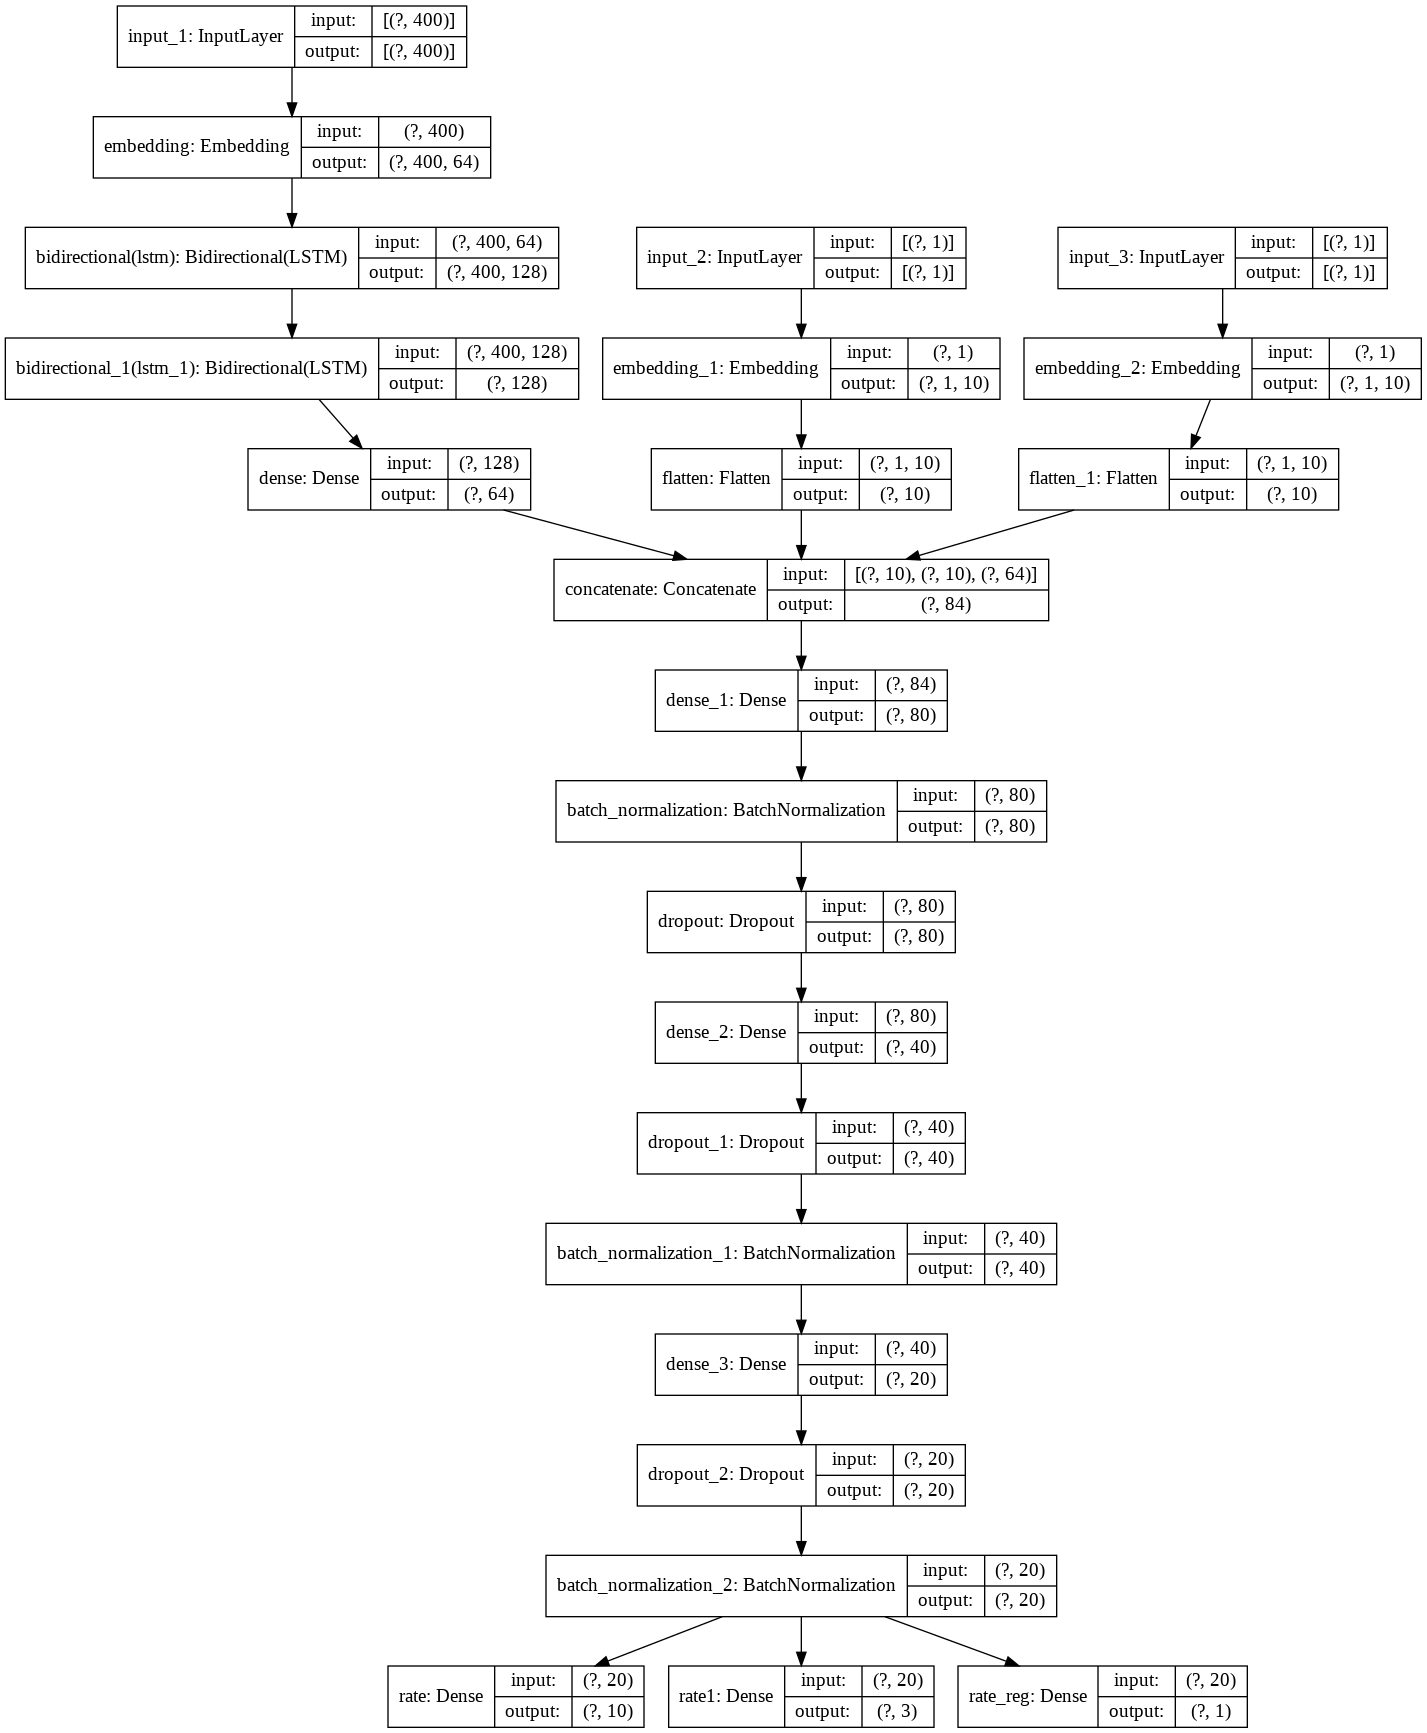

In [0]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

#### conversion to one hot variables

In [12]:
# convert integers to dummy variables (i.e. one hot encoded)
train_labels_one_hot = []
val_labels_one_hot = []


train_labels_one_hot.append(tf.keras.utils.to_categorical(train_labels[0]))
train_labels_one_hot.append(tf.keras.utils.to_categorical(train_labels[1]))

val_labels_one_hot.append(tf.keras.utils.to_categorical(val_labels[0]))
val_labels_one_hot.append(tf.keras.utils.to_categorical(val_labels[1]))

print(f"shape: {len(train_labels_one_hot)} one hot encoded: {train_labels_one_hot}")

shape: 2 one hot encoded: [array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)]


In [0]:
train_labels[0]

array([9, 9, 8, ..., 8, 9, 9])

#### callbacks

In [0]:
run_path = "/content/drive/My Drive/Colab Notebooks/zmum/models/three_unique"
earlyStopping = EarlyStopping(monitor='rate_accuracy', patience=10, verbose=0)
mcp_save = ModelCheckpoint(os.path.join(run_path, 'model-{epoch:03d}-{val_rate_accuracy:03f}-{val_rate1_accuracy:03f}.h5'),
                           save_best_only=True, monitor='rate_accuracy', patience=7)
reduce_lr_loss = ReduceLROnPlateau(monitor='rate_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4)

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]


#### model training and history

In [0]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/zmum/models/three_unique/model-002-0.441320-0.753879.h5")

model.compile(
    optimizer='adam',
    loss={
        "rate": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        "rate1": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        "rate_reg": tf.keras.losses.MeanAbsoluteError(),
    },
    loss_weights=[1.0, 0.2, 1],
    metrics=[['accuracy'], ['accuracy'], ['mae']]
)

In [0]:
num_epochs = 100

history = model.fit(
    {"input_1": train_padded, "input_2": X_train_enc[0], "input_3": X_train_enc[1]},
    {"rate": train_labels_one_hot[0], "rate1": train_labels_one_hot[1], "rate_reg": train_labels[0]},
    epochs=num_epochs,
    batch_size=100,
    callbacks=callbacks,
    validation_data=({"input_1": validation_padded, "input_2": X_val_enc[0], "input_3": X_val_enc[1]},
                    {"rate": val_labels_one_hot[0], "rate1": val_labels_one_hot[1], "rate_reg": val_labels[0]})
)

Epoch 1/100
1375/1375 [==============================] - 375s 273ms/step - loss: 3.2230 - rate_loss: 1.9707 - rate1_loss: 0.7377 - rate_reg_loss: 1.1048 - rate_accuracy: 0.4873 - rate1_accuracy: 0.8087 - rate_reg_mae: 1.1048 - val_loss: 3.5921 - val_rate_loss: 2.0229 - val_rate1_loss: 0.7945 - val_rate_reg_loss: 1.4103 - val_rate_accuracy: 0.4297 - val_rate1_accuracy: 0.7452 - val_rate_reg_mae: 1.4103 - lr: 0.0010
Epoch 2/100
1375/1375 [==============================] - 372s 270ms/step - loss: 3.1846 - rate_loss: 1.9647 - rate1_loss: 0.7329 - rate_reg_loss: 1.0733 - rate_accuracy: 0.4935 - rate1_accuracy: 0.8141 - rate_reg_mae: 1.0733 - val_loss: 3.6449 - val_rate_loss: 2.0156 - val_rate1_loss: 0.7921 - val_rate_reg_loss: 1.4710 - val_rate_accuracy: 0.4413 - val_rate1_accuracy: 0.7539 - val_rate_reg_mae: 1.4710 - lr: 0.0010
Epoch 3/100
1375/1375 [==============================] - 369s 269ms/step - loss: 3.1361 - rate_loss: 1.9562 - rate1_loss: 0.7253 - rate_reg_loss: 1.0348 - rate_accu

KeyboardInterrupt: ignored

In [0]:
plot_history(history)


NameError: ignored

#### confusion matrix

In [0]:
# predictions = model.predict([X_val_enc[0], X_val_enc[1], validation_padded])
predictions = model.predict({"input_1": validation_padded, "input_2": X_val_enc[0], "input_3": X_val_enc[1]})


In [15]:
print(predictions[0].shape, predictions[1].shape, predictions[2].shape)
predictions

(11665, 10) (11665, 3) (11665, 1)


[array([[1.22937923e-12, 2.08337401e-08, 1.09921015e-08, ...,
         1.83873141e-07, 6.67927321e-04, 9.99331772e-01],
        [6.48420246e-05, 7.78581125e-06, 1.46673210e-05, ...,
         7.89548576e-01, 9.42317620e-02, 1.45917165e-03],
        [2.00653858e-07, 4.37900053e-06, 4.93059451e-06, ...,
         2.51008086e-02, 6.32009923e-01, 3.41885328e-01],
        ...,
        [7.13105269e-11, 1.37251410e-09, 1.51450141e-09, ...,
         2.25355645e-08, 1.30950984e-05, 9.99986887e-01],
        [2.37627180e-08, 2.36761048e-06, 1.90781020e-06, ...,
         3.61467786e-02, 9.35232401e-01, 2.79003456e-02],
        [6.98757621e-13, 2.30529595e-09, 1.55705893e-09, ...,
         8.28846236e-09, 3.16419755e-05, 9.99968410e-01]], dtype=float32),
 array([[9.9999928e-01, 2.0377287e-10, 7.7446651e-07],
        [6.4559442e-01, 5.2007346e-04, 3.5388547e-01],
        [9.9954849e-01, 1.7823218e-07, 4.5131808e-04],
        ...,
        [9.9999571e-01, 1.9492962e-08, 4.3171040e-06],
        [9.997051

### Evaluation


In [16]:
metrics = model.evaluate(x={"input_1": validation_padded, "input_2": X_val_enc[0], "input_3": X_val_enc[1]},
                    y={"rate": val_labels_one_hot[0], "rate1": val_labels_one_hot[1], "rate_reg": val_labels[0]})
metrics

365/365 [==============================] - 67s 182ms/step - loss: 3.6449 - rate_loss: 2.0156 - rate1_loss: 0.7921 - rate_reg_loss: 1.4710 - rate_accuracy: 0.4413 - rate1_accuracy: 0.7539 - rate_reg_mae: 1.4710


[3.6449427604675293,
 2.0155632495880127,
 0.7921323180198669,
 1.4709510803222656,
 0.44132018089294434,
 0.7538791298866272,
 1.4709510803222656]

### Rate confusion matrix

#### Classification

Confusion matrix, without normalization
[[1329    0    0    0   43    0    0   21    8  130]
 [ 341    0    0    0   51    0    0   27    6   53]
 [ 255    0    0    0   65    0    0   34   16   56]
 [ 196    0    0    0   59    0    0   38   28   61]
 [ 223    0    0    0  126    0    0   79   54  120]
 [ 131    0    0    0   94    0    0   72   62   93]
 [  99    0    0    0   83    0    0  131  143  236]
 [ 115    0    0    0   84    0    0  179  289  671]
 [  90    0    0    0   60    0    0  107  296 1446]
 [ 211    0    0    0   37    0    0   70  229 3218]]


0.4413201885983712

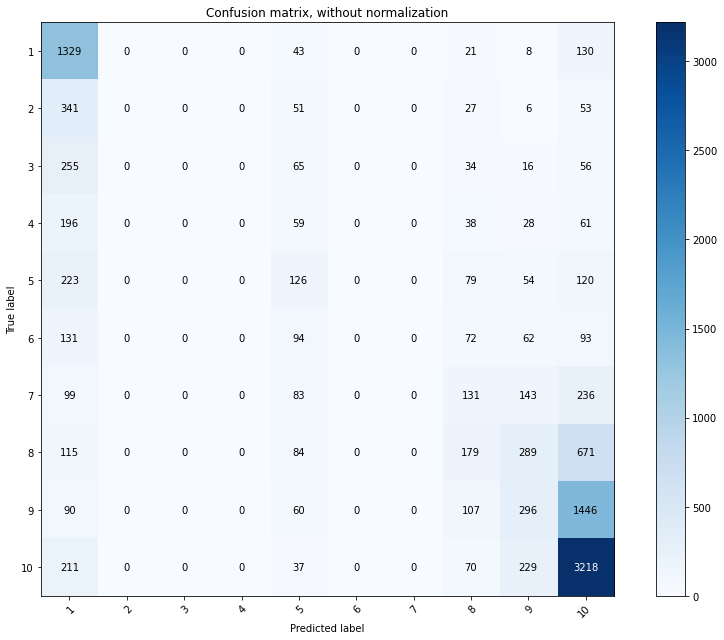

In [17]:
y_pred = np.argmax(predictions[0], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)


#### Rounding to nearest int

Confusion matrix, without normalization
[[1165   64   55   42   37   28   21   16   30   73]
 [ 275   26   25   23   35   20   16   12   17   29]
 [ 183   34   24   25   40   25   18   22   18   37]
 [ 140   21   20   21   38   24   17   35   30   36]
 [ 135   32   35   36   80   45   50   53   60   76]
 [  65   24   25   28   50   44   31   59   60   66]
 [  56   19   10   24   49   46   53   88  175  172]
 [  51   15   22   32   50   52   82  148  344  542]
 [  46   12   11   19   32   55   48   89  397 1290]
 [ 126   16   33   22   41   53   29   99  356 2990]]


0.424174882126018

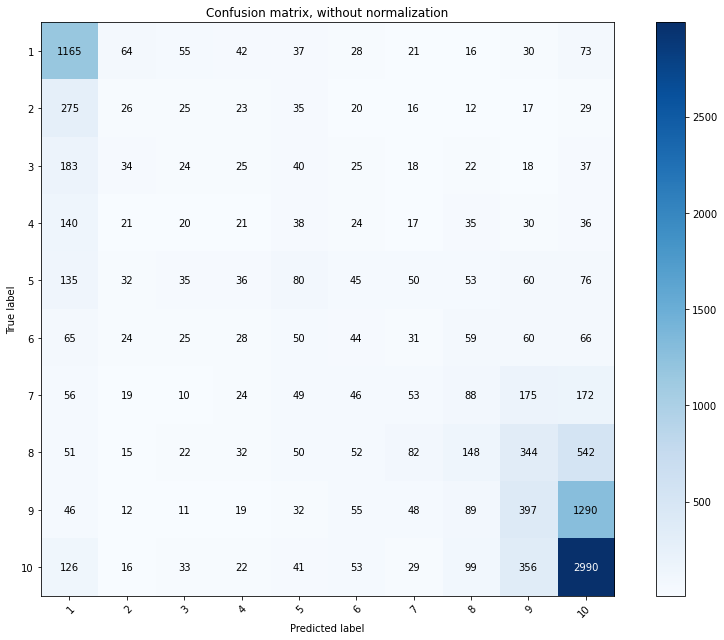

In [18]:
# y_pred = predictions[2].astype('int') 
y_pred = [round(elem[0]) for elem in predictions[2]]
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)


#### Float projection to int

Confusion matrix, without normalization
[[1200   55   57   30   35   27   17   23   87    0]
 [ 286   30   24   22   30   24    9   14   39    0]
 [ 199   31   21   31   34   24   16   24   46    0]
 [ 154   17   22   30   31   19   22   39   48    0]
 [ 155   28   36   53   72   46   42   69  101    0]
 [  76   20   27   38   57   33   35   73   93    0]
 [  61   18   19   28   51   55   57  164  239    0]
 [  59   22   19   44   53   67   90  285  699    0]
 [  53   10   14   26   45   49   65  246 1491    0]
 [ 133   26   31   19   50   46   56  224 3180    0]]


0.27595370767252464

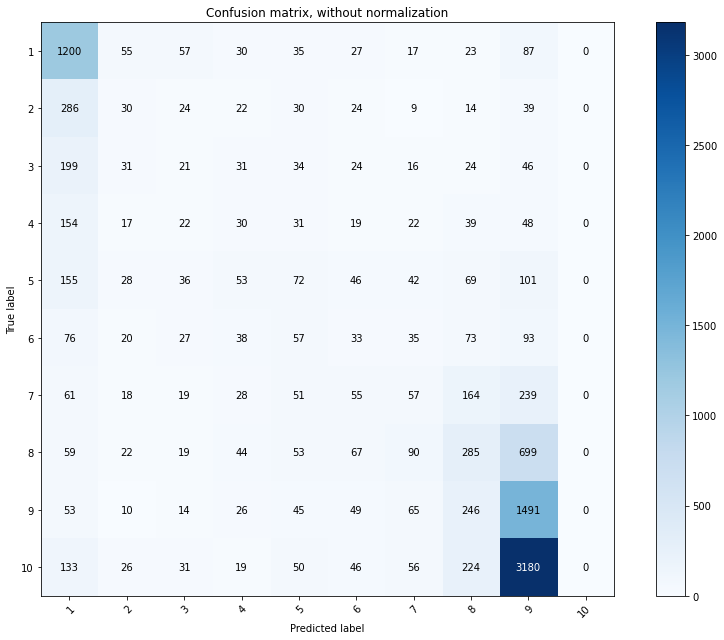

In [19]:
y_pred = predictions[2].astype('int') 
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)

### Rate1 confusion matrix

#### Classification


Confusion matrix, without normalization
[[6377  436  289]
 [ 306 1940  189]
 [ 993  658  477]]


0.7538791255893699

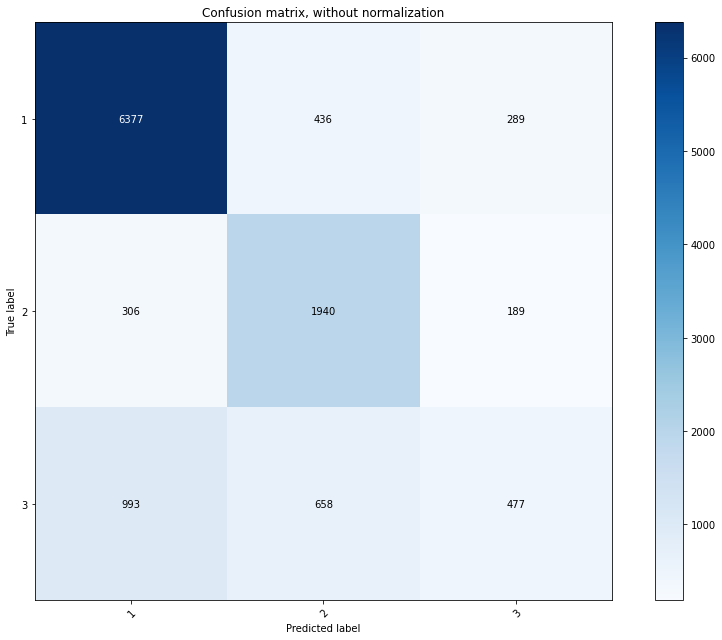

In [20]:
y_pred = np.argmax(predictions[1], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[1], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[1], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[1]) if x == y) / len(y_pred)


#### Based on rate


Confusion matrix, without normalization
[[6505  416  181]
 [ 351 1925  159]
 [1117  649  362]]


0.7537076725246464

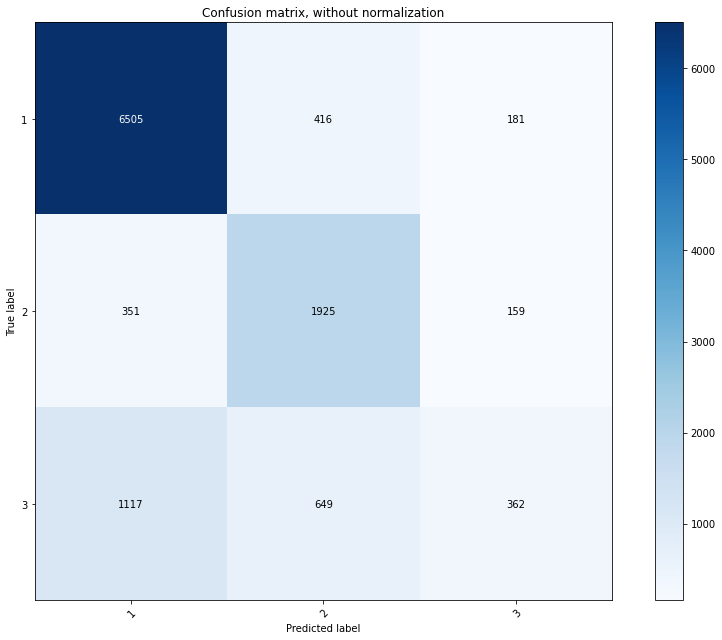

In [22]:
rate = np.argmax(predictions[0], axis=1)
rate+=1

y_pred = []
for i, elem in enumerate(rate):
    if elem <= 3:
        y_pred.append(1)
    elif 3 < elem < 8:
        y_pred.append(2)
    else:
        y_pred.append(0)

# y_pred = np.argmax(predictions[1], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[1], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[1], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[1]) if x == y) / len(y_pred)


In [0]:
train[['rate', 'rate1']]

rate   rate1
0         10    high
1         10    high
2          9    high
3          5  medium
4          9    high
...      ...     ...
137491    10    high
137492     3     low
137493     9    high
137494    10    high
137495    10    high

[137496 rows x 2 columns]

In [0]:
train_labels[1][3]

2

# Test predictions

In [0]:
pred_test = model.predict({"input_1": test_padded, "input_2": X_test_enc[0], "input_3": X_test_enc[1]})

In [16]:
pred_test

[array([[8.9363052e-11, 1.0160971e-09, 1.1955139e-09, ..., 1.8095735e-08,
         1.0177168e-05, 9.9998987e-01],
        [8.6251848e-06, 6.4375909e-06, 9.4607331e-06, ..., 6.0645235e-01,
         3.5914403e-01, 5.5815829e-03],
        [1.2544819e-12, 3.1537659e-09, 2.1984523e-09, ..., 1.9087347e-08,
         4.5550863e-05, 9.9995446e-01],
        ...,
        [4.8406076e-14, 1.4062846e-09, 6.9130002e-10, ..., 8.8445268e-10,
         2.1031779e-05, 9.9997902e-01],
        [5.4721717e-15, 1.7887386e-09, 6.5847455e-10, ..., 5.2543048e-10,
         3.5372101e-05, 9.9996459e-01],
        [6.5001376e-14, 1.4347058e-09, 7.2890916e-10, ..., 1.0900144e-09,
         2.0532876e-05, 9.9997950e-01]], dtype=float32),
 array([[9.99994397e-01, 2.82654948e-08, 5.61387196e-06],
        [9.65068161e-01, 2.86738268e-05, 3.49031836e-02],
        [9.99999166e-01, 6.15023366e-10, 8.86141834e-07],
        ...,
        [9.99999881e-01, 8.86017301e-11, 1.43662319e-07],
        [1.00000000e+00, 1.46376244e-11, 

In [0]:
rate = np.argmax(pred_test[0], axis=1)
rate+=1
rate1_tmp = np.argmax(pred_test[1], axis=1)
rate1 = []
for i, elem in enumerate(rate):
    if elem <= 3:
        rate1.append("low")
    elif 3 < elem < 8:
        rate1.append("medium")
    else:
        rate1.append("high")
rate1 = np.asanyarray(rate1)
df = pd.DataFrame(data = np.concatenate([np.expand_dims(rate, axis=1), np.expand_dims(rate1, axis=1)], axis=1), columns=["rate", "rate1"])
df.head(100)
df.to_csv("/content/drive/My Drive/Colab Notebooks/zmum/models/results_unique.csv")